In [1]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
import qmnet_model as qnm
import qmnet_tools as qnt
import tensorflow as tf
import re
import numpy as np
import qmnet_layer as qnl

%matplotlib inline

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 128

In [42]:
molstr_list_H2 = ['HH']
molstr_list_LiH = ['LiH']
molstr_list = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
    'HeHe',
    'HeLi+',
    'HeBe',
    'LiLi',
    'LiBe+',
    'BeBe',
]

In [43]:
def get_inp_grp(molstr_list, resolution):
    inp_grp = []
    #inp_dump = []
    for molstr in molstr_list:
        if '+' in molstr:
            charge = 1
        elif '-' in molstr:
            charge = -1
        else:
            charge = 0
        alist = re.findall('[A-Z][a-z]*', molstr)
        Zs = [qtk.n2Z(a) for a in alist]
        inp_list = []
        inp_grp.append(inp_list)
        #inp_dump.append(inp_list)
        res = resolution
        for R in np.arange(0.3, 4.0 + res, res):
            mol = qtk.Molecule()
            ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
            mol.build(ZR)
            mol.charge = charge
            mol.name = mol.name + '_%s' % str(R)
            inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
            try:
                inp.run()
                D, U = np.linalg.eigh(inp.olp)
                inp.X = U / np.sqrt(D)

                # to save inps into pickle file
                #inp.delete_ht_types()
                #inp.delete_matrices()

                inp_list.append(inp)
            except:
                pass
        print "%s finished" % mol.name
    print [len(inp) for inp in inp_grp]
    return inp_grp

In [44]:
inp_grp = get_inp_grp(molstr_list, resolution=0.005)

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
He2_4.0 finished
He1Li1_4.0 finished
He1Be1_4.0 finished
Li2_4.0 finished
Li1Be1_4.0 finished
Be2_4.0 finished
[741, 741, 741, 563, 741, 741, 741, 741, 741, 741]


In [55]:
inp_grp_dense = get_inp_grp(molstr_list, resolution=0.001)

H2_4.001 finished
H1He1_4.001 finished
H1Li1_4.001 finished
H1Be1_4.001 finished
He2_4.001 finished
He1Li1_4.001 finished
He1Be1_4.001 finished
Li2_4.001 finished
Li1Be1_4.001 finished
Be2_4.001 finished
[3702, 3702, 3702, 2814, 3702, 3702, 3702, 3702, 3702, 3702]


In [47]:
def get_C_prd(qmnet_model, model_file_name, inp_in, get_y=False):
    I_list, Er_list, occ_list, nn_list, C_list, y_list = qnt.tfIO_batch(inp_in, 100)
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
        y_prd, C_prd, param = qmnet_model(g, I_list[0][0].shape[-1])
        I, Er, occ, nn, keep_prob = param
        #y_prd = qnl.HF_energy_layer(I, Er, occ, nn, C_prd)
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, model_file_name)
            C_out_list, y_out_list = [], []
            for I_v, Er_v, occ_v, nn_v in zip(I_list, Er_list, occ_list, nn_list):
                valid_dict = {I:I_v, Er:Er_v, occ:occ_v, nn:nn_v, keep_prob:1.0}
                C_out, y_out = sess.run([C_prd, y_prd], feed_dict=valid_dict)
                C_out_list.extend(C_out)
                y_out_list.extend(y_out)
            if not get_y:
                return C_out_list, y_out_list
            else:
                return C_out_list, y_out_list, np.concatenate(y_list)

In [102]:
[len(inp) for inp in inp_grp_dense]

[3702, 3702, 3702, 2814, 3702, 3702, 3702, 3702, 3702, 3702]

In [116]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)

valid_ind = 0
train_list = [0,1,2,3]
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, valid_ind, train_list)
inp_dense, _, _ = qnt.train_test_valid(inp_grp_dense, valid_ind, train_list)

qm_model = qnm.I0_S1x2_d_S1x2_O1x3
#model_root = '%s_simple_test' % molstr_list[mol_ind]
#model_root = 'A2_3_simple_test'
#model_root = 'A2_increament_simple_test_04'
model_root = 'A2_increment_SCF_04'
model_file = "%s.ckpt" % model_root
model_hist = "%s_hist.pkl" % model_root

In [114]:
C_tar, E_tar = get_C_prd(qm_model, model_file, inp_train)
C_prd, E_prd = get_C_prd(qm_model, model_file, inp_test)
C_val, E_val = get_C_prd(qm_model, model_file, inp_valid)
#C_prd2, E_prd2 = get_C_prd(qm_model, model_file, inp_valid2)
C_dense, E_dense = get_C_prd(qm_model, model_file, inp_dense)

# [train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist]
opt_hist = qtk.load(model_hist)
C_hist = np.array(opt_hist[-3])
print 'done'

INFO:tensorflow:Restoring parameters from A2_increment_SCF_04.ckpt
INFO:tensorflow:Restoring parameters from A2_increment_SCF_04.ckpt
INFO:tensorflow:Restoring parameters from A2_increment_SCF_04.ckpt
INFO:tensorflow:Restoring parameters from A2_increment_SCF_04.ckpt
done


(-2.92, -2.84)

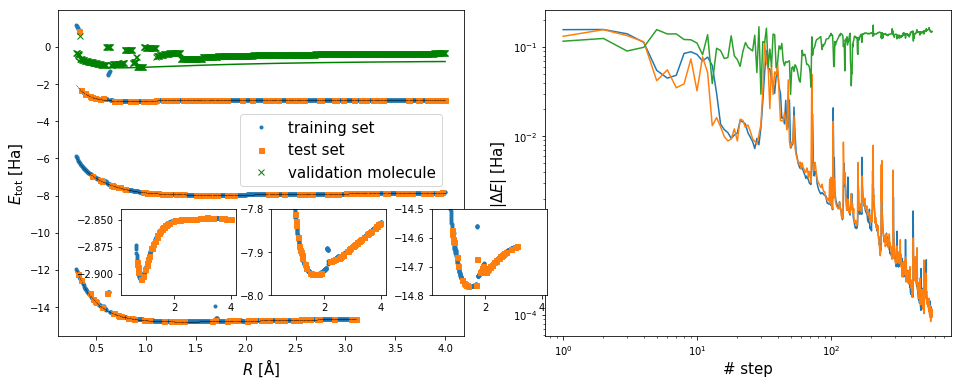

In [186]:
E_true = np.array([inp.Et for inp in inp_train]) 
E_val_true = np.array([inp.Et for inp in inp_valid])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])
R_dense = np.array([inp.molecule.R[1,0] for inp in inp_dense])
R_val = np.array([inp.molecule.R[1,0] for inp in inp_valid])

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,6))
ax1.plot(R_tar, E_tar, ls='', marker='.', label='training set')
ax1.plot(R_prd, E_prd, ls='', marker='s', label='test set', ms=5)
#ax1.plot(R_dense, E_dense, color='y', marker='^', ls='')
ax1.plot(R_val, E_val, color='g', ls='', marker='x', label='validation molecule')
ax1.plot(R_val, E_val_true, color='g')
ax1.plot(R_tar, E_true, ls='', marker='.', color='k', markersize=0.2)
#ax1.set_ylim(-2.9,-2.8)
for i in [0,1, 2]:
    ax2.loglog(opt_hist[i])
    
ax1.set_ylabel(r'$E_{\mathrm{tot}}$ [Ha]', fontsize=15)
ax1.set_xlabel(r'$R$ [$\mathrm{\AA}$]', fontsize=15)
ax2.set_ylabel(r'$|\Delta E|$ [Ha]', fontsize=15)
ax2.set_xlabel(r'# step', fontsize=15)
l = ax1.legend(loc=(.45,0.46), fontsize=15)


c = plt.axes([.45, .22, .1, .2])
c.plot(R_tar, E_tar, ls='', marker='.')
c.plot(R_prd, E_prd, ls='', marker='s', ms=5)
c.set_ylim(-14.8,-14.5)
b = plt.axes([.31, .22, .1, .2])
b.plot(R_tar, E_tar, ls='', marker='.')
b.plot(R_prd, E_prd, ls='', marker='s', ms=5)
b.set_ylim(-8,-7.8)
a = plt.axes([.18, .22, .1, .2])
a.plot(R_tar, E_tar, ls='', marker='.')
a.plot(R_prd, E_prd, ls='', marker='s', ms=5)
a.set_ylim(-2.92,-2.84)